# Adjective Representation PCA

Let's look at the representations induced in a noun after being described by various adjectives. 

We will sample adjectives from Webster's dictionary, and we will use a pre-defined single-token noun/prompt for now. 

An exciting extension for understanding the **temporality** of emotion in LLMs by examining structure in the representations of the noun after T tokens have passed. Will the strength of the "emotion signals" dissapate over time? Will we see commonality in the representations when projected along an "emotional access" (PCA dimension)? 

In [1]:
# Imports 
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

from sklearn.decomposition import PCA

## Load Mistral-7b

Best 7b parameter on the market. For a rough sense of how "smart" Mistral-7b is, 
it's 8 x 7b mixture-of-experts cousin has the same ELO (1118) as GPT-3.5-Turbo on HuggingFace. 
For context, GPT-4 has an ELO of 1253. 

Hopefully being a relatively "intelligent" model will make it represent emotions more
clearly/reliably. If these results are promising, we can always re-run them on
the 8 x 7b Mistral variant. 

In [2]:
# load Mistral-7b -- one of the smartest 7b model on the market 
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1", add_prefix_space=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1").to('cuda')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
# Sanity check: What is the model loss on this sample input sentence? 
input_str = "Bob is extremely abashed. Therefore, Bob" 
input_ids = tokenizer.encode(input_str, return_tensors="pt").to('cuda')

# Generate the output
output = model(input_ids, labels=input_ids)
loss = output.loss
print("Loss: ", loss.item())

Loss:  5.585555076599121


## Load Webster's Dictionary

We are going to pull the [Webster's Unabridged Dictionary](https://www.gutenberg.org/ebooks/29765)
from project Gutenberg and parse it to find adjectives. 

In [188]:
# download https://www.gutenberg.org/ebooks/29765.txt.utf-8 using requests
# check if Websters_English_Dictionary.txt exists
import os 
import requests

if not os.path.exists('Websters_English_Dictionary.txt'): 
    url = "https://www.gutenberg.org/ebooks/29765.txt.utf-8"
    response = requests.get(url)
    text = response.text
    print("Length of text response: ", len(text))

    # write to external text file 
    with open("Websters_English_Dictionary.txt", "w") as file:
        file.write(text)
else: 
    # load the text file
    print("Loading text file")
    with open("Websters_English_Dictionary.txt", "r") as file:
        text = file.read()

Loading text file


In [189]:
# regular expression to find all lines that have any number of capital letters 
# followed by any number of white space characters followed by the end of line. 
import re
pattern = r"[A-Z]+\s*$\n[^,]+, a\."
matches = re.findall(pattern, text, re.MULTILINE)
print("Number of adjective entry matches: ", len(matches))

Number of adjective entry matches:  25866


In [190]:
# picking out just the adjective
pattern = r"[A-Z]+\n"
adjectives = [re.findall(pattern, x, re.MULTILINE)[0][:-1] for x in matches]

adjectives = [x.lower() for x in adjectives] # make lowercase

adjectives[:15] # sanity check 

['abactinal',
 'abandoned',
 'abased',
 'abatable',
 'abatised',
 'abbatial',
 'abbatical',
 'abbreviate',
 'abbreviated',
 'abbreviatory',
 'abderian',
 'abdicable',
 'abdicant',
 'abdicative',
 'abditive']

## Dataset Generation 

Let's format it as something like a statement of fact about "James"

```
Bob is extremely abderian. Therefore, Bob 
                   {adjective}       {examine these representations}
```

In [191]:
# template_string = "Alice is extremely {}. Therefore, Alice"
template_string = "Bob is extremely {}, so Bob"

# generate a sentence for each adjective
sentences = [template_string.format(x) for x in adjectives]

# tokenize the sentences 
tokenizer.pad_token = tokenizer.eos_token
input_ids = tokenizer(sentences, 
                      return_tensors="pt", 
                      padding=True, 
                      truncation=True, 
                      max_length=128, 
                      add_special_tokens=True, 
                      return_attention_mask=True)
input_ids.keys()

dict_keys(['input_ids', 'attention_mask'])

Text(0.5, 1.0, 'Histogram of attention mask sums')

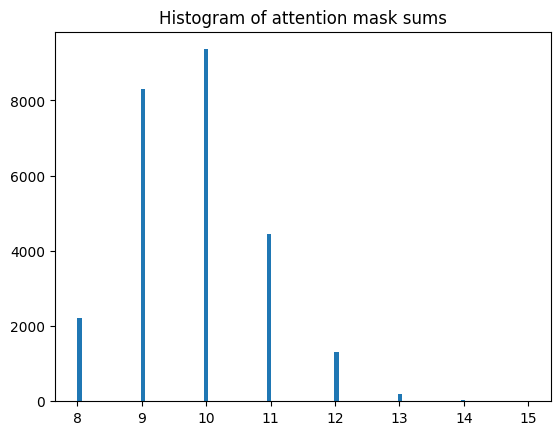

In [192]:
x = input_ids['attention_mask'].sum(1) 
# histogram of x
plt.hist(x.numpy(), bins=100)
plt.title("Histogram of attention mask sums")

In [193]:
print("SELECTING ONLY THE SENTENCES THAT HAVE 10 TOKENS")
selection_mask = x == 8

# select the sentences that have 10 tokens
input_ids['input_ids'] = input_ids['input_ids'][selection_mask]
input_ids['attention_mask'] = input_ids['attention_mask'][selection_mask]

# adjectives selection
adjectives = [adjectives[i] for i in range(len(adjectives)) if selection_mask[i]]

print("Number of selected sentences: ", input_ids['input_ids'].shape[0])

SELECTING ONLY THE SENTENCES THAT HAVE 10 TOKENS
Number of selected sentences:  2226


In [194]:
adjectives[:10]

['abandoned',
 'able',
 'cited',
 'abrupt',
 'absent',
 'absolute',
 'abstract',
 'absurd',
 'accept',
 'acceptable']

In [195]:
tokenizer.batch_decode(input_ids['input_ids'][1:10, :])

['</s></s></s></s></s></s></s><s> Bob is extremely able, so Bob',
 '</s></s></s></s></s></s></s><s> Bob is extremely cited, so Bob',
 '</s></s></s></s></s></s></s><s> Bob is extremely abrupt, so Bob',
 '</s></s></s></s></s></s></s><s> Bob is extremely absent, so Bob',
 '</s></s></s></s></s></s></s><s> Bob is extremely absolute, so Bob',
 '</s></s></s></s></s></s></s><s> Bob is extremely abstract, so Bob',
 '</s></s></s></s></s></s></s><s> Bob is extremely absurd, so Bob',
 '</s></s></s></s></s></s></s><s> Bob is extremely accept, so Bob',
 '</s></s></s></s></s></s></s><s> Bob is extremely acceptable, so Bob']

In [196]:
input_ids['attention_mask'][:, -4:] -= 1
input_ids['attention_mask'][:, 0]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [202]:
input_ids['attention_mask'].shape

torch.Size([2226, 15])

In [203]:
# input_ids['input_ids'][:4, :]A
print(input_ids['attention_mask'][0, :].tolist())

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]


In [204]:
input_ids['input_ids'].shape

torch.Size([2226, 15])

In [205]:
tokenizer.batch_decode(input_ids['input_ids'][:5, :])

['</s></s></s></s></s></s></s><s> Bob is extremely abandoned, so Bob',
 '</s></s></s></s></s></s></s><s> Bob is extremely able, so Bob',
 '</s></s></s></s></s></s></s><s> Bob is extremely cited, so Bob',
 '</s></s></s></s></s></s></s><s> Bob is extremely abrupt, so Bob',
 '</s></s></s></s></s></s></s><s> Bob is extremely absent, so Bob']

In [206]:
def get_bob_vals(past_kvs): 
    """
    Args: 
        `past_kvs`: model output['past_key_values'] from running a batch of 
        left-padded sentences through the model.

        Accepts `past_kvs`, a tuple of length NUM_LAYERS (32), each containing a 
        2-long tuple (for keys and values respectively), each containing a torch 
        Tensor of shape [batch, num_heads, seq_len, head_dim] (for values). 

    Returns: 
        `bob_kvs`: list of length BATCH_SIZE with some numpy arrays representing 
        of shape [num_layers, num_heads, head_dim]
    """

    # iterate thru batch size 
    BATCH_SIZE = past_kvs[0][1].shape[0]

    batch_bob_values = []
    for batch_el in range(BATCH_SIZE): 
        # aggregate representations from across the layers 
        bob_numpy_arrays = []
        for layer in range(len(past_kvs)): 
            bob_layer_l_value = past_kvs[layer][1][batch_el, :, -1, :].detach().cpu().numpy()
            # print("Bob layer_l_value shape: ", bob_layer_l_value.shape)

            # unsqueeze on dimension zero
            bob_numpy_arrays.append(bob_layer_l_value[np.newaxis, ...])
        
        # merge on axis 0
        bob_numpy_arrays_conc = np.concatenate(bob_numpy_arrays, axis=0)
        # print("Bob numpy arrays shape (post-concatenation to combine layers)", bob_numpy_arrays_conc.shape)
        # bob_numpy_arrays now has shape n_layers = 32, n_heads = 8, embed_dim=128

        # add it to the list
        batch_bob_values.append(bob_numpy_arrays_conc)


    return batch_bob_values


In [207]:
# iterate thru input_ids
BATCH_SIZE = 1

past_values_bob = [] # list of length NUM_ADJECTIVES, each element is
                     # a numpy array of bob value reps of shape [num_layers=32, n_heads=8, embed_dim=128]

losses = []

print("Generating Bob representations...")
# pbar = tqdm(total=len(input_ids["input_ids"]) // BATCH_SIZE + 1)
pbar = tqdm(range(len(input_ids["input_ids"]) // BATCH_SIZE))
for i in pbar:
    batch_ids = input_ids["input_ids"][i * BATCH_SIZE: (i + 1) * BATCH_SIZE].to(model.device)
    batch_attn = input_ids["attention_mask"][i * BATCH_SIZE: (i + 1) * BATCH_SIZE].to(model.device)[:, :]
    # print("Batch ids shape (batch, ): ", batch_ids.shape)
    # print("Input string: ", tokenizer.decode(batch_ids[15, :]))
    # print(f"Final token: `{tokenizer.decode(batch_ids[0, -1:])}`")
    outputs = model.forward(batch_ids[:, :], return_dict=True, labels=batch_ids[:, :], attention_mask=batch_attn)
    # print("Output keys: ", outputs.keys())

    past_kvs = outputs['past_key_values']

    # print("Past key values (n_layers): ", len(past_kvs))
    # print("Batch size (reconstructed): ", past_kvs[0][1].shape[0])
    bob_numpy_arrays = get_bob_vals(past_kvs) # [batch_size], each a numpy array of shape [num_layers=32, n_heads=8, embed_dim=128]

    # let's add this to the past_values_bob 
    past_values_bob += bob_numpy_arrays


    # storing the loss value
    loss = outputs['loss'].detach().cpu().numpy()
    losses.append(loss)

    # update with loss value
    pbar.set_postfix({"loss": loss})

Generating Bob representations...


100%|█████████▉| 2226/2227 [01:37<00:00, 22.94it/s, loss=7.893741] 


RuntimeError: CUDA error: invalid configuration argument
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [208]:
tokenizer.decode(input_ids['input_ids'][2225, :])

'</s></s></s></s></s></s></s><s> Bob is extremely polar, so Bob'

In [209]:
losses = [float(x) for x in losses]
print("Mean loss: ", np.mean(losses))

Mean loss:  7.70038367988607


In [210]:
print("Number of bob representations: ", len(past_values_bob))
print("Number of adjectives: ", len(adjectives))
print("Shape of individual bob value representation: ", past_values_bob[0].shape)
print("\t[num_layers=32, n_heads=8, embed_dim=128]")
print("Length of losses: ", len(losses))
print("Loss[0]: ", losses[0])

Number of bob representations:  2226
Number of adjectives:  2226
Shape of individual bob value representation:  (32, 8, 128)
	[num_layers=32, n_heads=8, embed_dim=128]
Length of losses:  2226
Loss[0]:  7.664345741271973


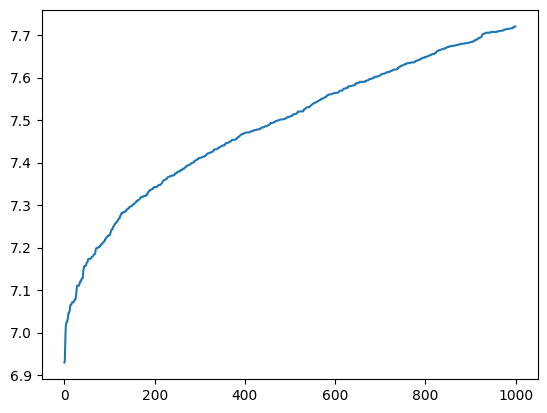

In [232]:
plt.plot(losses)

In [212]:
print("Shape of past_values_bob: ", past_values_bob.shape)
print("Length of losses: ", len(losses))

Shape of past_values_bob:  (2226, 32, 8, 128)
Length of losses:  2226


In [213]:
type(past_values_bob)

numpy.ndarray

## PCA on Bob Representations

Gotta flatten the past_values_bob[i] value reps, make a big ole matrix, and do 
PCA on it, and hope my computer doesn't explode. 

In [214]:
flat_past_values_bob = []

for i in range(past_values_bob.shape[0]): 
    flat_past_values_bob.append(past_values_bob[i, :, :, :].flatten())

past_values_bob_matrix = np.array(flat_past_values_bob)
print("Past values bob matrix shape (num_adjectives, token_value_dim): ", past_values_bob_matrix.shape)

# save to disk 
np.save("bob_representations_flat.npy", past_values_bob_matrix)

Past values bob matrix shape (num_adjectives, token_value_dim):  (2226, 32768)


Losses shape:  (1000,)
Past values bob matrix shape (num_adjectives, token_value_dim):  (1000, 32768)


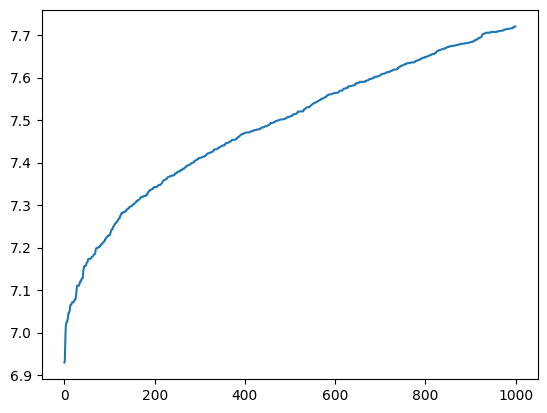

In [215]:
# select the top 1000 in terms of loss 
top_1000_indices = np.argsort(losses)[100:1000]
losses_filtered = np.array(losses)[top_1000_indices]

past_values_bob_matrix_filtered = past_values_bob_matrix[top_1000_indices, :]

adjectives_filtered = [adjectives[i] for i in top_1000_indices]

print("Losses shape: ", losses_filtered.shape)
print("Past values bob matrix shape (num_adjectives, token_value_dim): ", past_values_bob_matrix_filtered.shape)
plt.plot(losses_filtered)

# send to disk 
np.save("bob_representations_flat_top1000.npy", past_values_bob_matrix_filtered)
np.save("losses_top1000.npy", losses_filtered)

In [216]:
adjectives[:10]

['helpful',
 'professional',
 'intelligent',
 'friendly',
 'patient',
 'busy',
 'busy',
 'talented',
 'reliable',
 'positive']

In [217]:
# Now we do pca
# load from disk 
# past_values_bob_matrix = np.load("bob_representations_flat.npy")
# print("past_value_bob_matrix shape: ", past_values_bob_matrix.shape)

# load from disk (optional)
# past_values_bob_matrix = np.load("bob_representations_flat_top1000.npy")
# print("past_value_bob_matrix shape: ", past_values_bob_matrix.shape)

In [221]:
# doing pca
# Initialize PCA to keep the first 3 principal components
pca = PCA(n_components=3)

# Fit PCA on your data and transform it to get the 3-dimensional representation
transformed_data = pca.fit_transform(past_values_bob_matrix)

# transformed_data now has shape [N, 3], where N is the number of examples
print("Transformed data shape:", transformed_data.shape)
print("First 3-dimensional representation:", transformed_data[0])


Transformed data shape: (1000, 3)
First 3-dimensional representation: [ 7.254343e-04 -2.602091e-13  4.883106e-16]


In [231]:
is_helpful = [x == 'helpful' for x in adjectives]
is_helpful = np.array(is_helpful)
adjectives[0]

'helpful'

## Plotly Interactive Scatter Plot

We will output this as an HTML file you can view with the browser to explore the 
data space. 

In [226]:
import plotly.graph_objects as go

# Create a list of colors that scales with the losses 
colors = np.array(losses) - np.min(losses)
colors = colors / np.max(colors)


# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=transformed_data[:, 0],
    y=transformed_data[:, 1],
    z=transformed_data[:, 2],
    text=adjectives,  # Set the labels for each point
    mode='markers+text',  # Choose to have both markers and text
    marker=dict(
        size=5,
        color=colors,  # Set the color of each point
        opacity=0.8
    )
)])

# Customize the layout of the plot
fig.update_layout(
    title=f'Mistral 7b, top {len(losses)}: PCA on Bob reps in "Bob is extremely <adjective>. Therefore <Bob>" sentences',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

# Export the plot as an HTML file
fig.write_html('bob_adjective_reps.html')